# **Importing Libraries**

In [88]:
import torch
import torchaudio
import pandas as pd
import numpy as np
import os
import torchaudio
import librosa
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from transformers import ClapProcessor, ClapModel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import soundfile as sf
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import catboost as cb

In [2]:
# Define dataset path (modify this as per your Kaggle directory structure)
DATASET_PATH = "/kaggle/input/telugu-hate-speech"

In [3]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using CPU")

Using GPU: Tesla T4


# **Loading the Text Data**

In [4]:
# Extract binary label based on filename
def extract_label(filename):
    if filename.startswith("H_TE_"):
        return 1  # Hate Speech
    elif filename.startswith("NH_TE_"):
        return 0  # Non-Hate Speech
    else:
        raise ValueError(f"Unexpected filename format: {filename}")

In [46]:
# Load text data
text_data_path = os.path.join(DATASET_PATH, "Telugu Hate Speech Text data.xlsx")
df_text = pd.read_excel(text_data_path)

# Strip any leading/trailing spaces from column names
df_text.columns = df_text.columns.str.strip()
df_text["AUDIO FILE NAME"] = df_text["AUDIO FILE NAME"].astype(str).str.strip()

# Extract binary labels
df_text["Binary Label"] = df_text["AUDIO FILE NAME"].apply(extract_label)

# Convert labels to integers
df_text["Binary Label"] = df_text["Binary Label"].astype(int)

# Keep only relevant columns
df_text = df_text[['AUDIO FILE NAME', 'Binary Label', 'SHORT LABLE', 'TRANSCRIPTION']]

In [6]:
print("Label distribution:\n", df_text['Binary Label'].value_counts())

Label distribution:
 Binary Label
1    393
0    208
Name: count, dtype: int64


In [45]:
'''# Function to split long text into multiple chunks of max 512 tokens
def split_text_into_chunks(text, max_length=512):
    tokens = processor.tokenizer(text, truncation=False, add_special_tokens=False)["input_ids"]
    
    if len(tokens) <= max_length:
        return [text]  # No need to split
    
    chunks = []
    for i in range(0, len(tokens), max_length):
        chunk = tokens[i:i+max_length]
        chunk_text = processor.tokenizer.decode(chunk, skip_special_tokens=True)
        chunks.append(chunk_text)
    
    return chunks

# Apply text chunking
df_text["Text Chunks"] = df_text["TRANSCRIPTION"].apply(split_text_into_chunks)
df_text'''

'# Function to split long text into multiple chunks of max 512 tokens\ndef split_text_into_chunks(text, max_length=512):\n    tokens = processor.tokenizer(text, truncation=False, add_special_tokens=False)["input_ids"]\n    \n    if len(tokens) <= max_length:\n        return [text]  # No need to split\n    \n    chunks = []\n    for i in range(0, len(tokens), max_length):\n        chunk = tokens[i:i+max_length]\n        chunk_text = processor.tokenizer.decode(chunk, skip_special_tokens=True)\n        chunks.append(chunk_text)\n    \n    return chunks\n\n# Apply text chunking\ndf_text["Text Chunks"] = df_text["TRANSCRIPTION"].apply(split_text_into_chunks)\ndf_text'

In [47]:
df_text

,AUDIO FILE NAME,Binary Label,SHORT LABLE,TRANSCRIPTION
0,H_TE_001_R_F_001_001,1,R,ఎస్సీలుగా పుట్టాలని ఎవరు కోరుకుంటారు
1,H_TE_001_R_F_001_002,1,R,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు అం...
2,H_TE_001_R_M_001_003,1,R,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు
3,H_TE_001_R_M_001_004,1,R,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు డబ...
4,H_TE_001_R_M_001_005,1,R,అందరూ రాజుల కులంలో పుడితే రాజ్యాన్ని ఎలచ్చనుకు...
...,...,...,...,...
596,NH_TE_003_N_F_012_003,0,N,నడిపించారు హీరోలకి అంటూవుంటాంకదా సినిమామొతాన్న...
597,NH_TE_003_N_F_013_001,0,N,మన పక్కన ఎంత ఉంది అన్నది కాదు నాన్న ఎవరు ఉన్నా...
598,NH_TE_003_N_F_013_002,0,N,ఒక అమ్మాయికి ఫాదర్ ముందుండాలి బ్రదర్ వెనకుండాల...
599,NH_TE_003_N_M_014_001,0,N,ఇంకో విచిత్రం ఏంటంటే మన లైఫ్ ని ఇంటరెస్టింగ్ గ...


# **Loading the Audio Data**

In [7]:
# Function to construct the full file path (supports both .mp3 and .wav)
def get_audio_path(filename):
    """
    Constructs the full file path for an audio sample, supporting both .mp3 and .wav formats.
    """
    # Define base directory
    base_dir = os.path.join(DATASET_PATH, "Hate") if filename.startswith("H_TE") else os.path.join(DATASET_PATH, "Non Hate")

    # Identify the correct subfolder for hate speech files
    if filename.startswith("H_TE"):
        if "_C_" in filename:
            subfolder = "Character Assassination"
        elif "_G_" in filename:
            subfolder = "Gender"
        elif "_P_" in filename:
            subfolder = "Political"
        elif "_R_" in filename:
            subfolder = "Religion"
        else:
            raise ValueError(f"Unknown Hate Speech Category: {filename}")

        full_dir = os.path.join(base_dir, subfolder)
    else:
        full_dir = base_dir  # Non-Hate samples are directly in "Non Hate"

    # Check for file existence with both extensions
    mp3_path = os.path.join(full_dir, filename + ".mp3")
    wav_path = os.path.join(full_dir, filename + ".wav")

    if os.path.exists(mp3_path):
        return mp3_path
    elif os.path.exists(wav_path):
        return wav_path
    else:
        raise FileNotFoundError(f"Audio file not found: {mp3_path} or {wav_path}")

In [48]:
audio_df = pd.DataFrame()
audio_df["Audio Name"] = df_text["AUDIO FILE NAME"]
audio_df["Binary Label"] = df_text["Binary Label"]
audio_df["SHORT LABLE"] = df_text["SHORT LABLE"]

# Apply function to get full audio paths
audio_df["Audio Path"] = audio_df["Audio Name"].apply(get_audio_path)

In [49]:
RESAMPLED_AUDIO_PATH = "/kaggle/working/resampled_audios"

# Ensure the resampled audio directory exists
os.makedirs(RESAMPLED_AUDIO_PATH, exist_ok=True)

In [57]:
def resample_and_save_audio(df, output_dir, target_sr=48000):
    os.makedirs(output_dir, exist_ok=True)
    
    resampled_paths = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Resampling Audio"):
        original_path = row["Audio Path"]
        new_path = os.path.join(output_dir, os.path.basename(original_path))  # Save with same filename
        
        # Load audio
        audio, sr = librosa.load(original_path, sr=None)
        
        # Resample to target sampling rate
        audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        
        # Save resampled audio
        sf.write(new_path, audio_resampled, target_sr, format='MP3')
        resampled_paths.append(new_path)
    
    df["Resampled Path"] = resampled_paths
    return df

# Apply resampling
audio_df = resample_and_save_audio(audio_df, RESAMPLED_AUDIO_PATH)

Resampling Audio: 100%|██████████| 601/601 [02:46<00:00,  3.61it/s]


In [58]:
audio_df

,Audio Name,Binary Label,SHORT LABLE,Audio Path,Resampled Path
0,H_TE_001_R_F_001_001,1,R,/kaggle/input/telugu-hate-speech/Hate/Religion...,/kaggle/working/resampled_audios/H_TE_001_R_F_...
1,H_TE_001_R_F_001_002,1,R,/kaggle/input/telugu-hate-speech/Hate/Religion...,/kaggle/working/resampled_audios/H_TE_001_R_F_...
2,H_TE_001_R_M_001_003,1,R,/kaggle/input/telugu-hate-speech/Hate/Religion...,/kaggle/working/resampled_audios/H_TE_001_R_M_...
3,H_TE_001_R_M_001_004,1,R,/kaggle/input/telugu-hate-speech/Hate/Religion...,/kaggle/working/resampled_audios/H_TE_001_R_M_...
4,H_TE_001_R_M_001_005,1,R,/kaggle/input/telugu-hate-speech/Hate/Religion...,/kaggle/working/resampled_audios/H_TE_001_R_M_...
...,...,...,...,...,...
596,NH_TE_003_N_F_012_003,0,N,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...,/kaggle/working/resampled_audios/NH_TE_003_N_F...
597,NH_TE_003_N_F_013_001,0,N,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...,/kaggle/working/resampled_audios/NH_TE_003_N_F...
598,NH_TE_003_N_F_013_002,0,N,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...,/kaggle/working/resampled_audios/NH_TE_003_N_F...
599,NH_TE_003_N_M_014_001,0,N,/kaggle/input/telugu-hate-speech/Non Hate/NH_T...,/kaggle/working/resampled_audios/NH_TE_003_N_M...


# **Checking for any missing samples**

In [51]:
import os

# Check if all audio files exist
missing_audio_files = audio_df[~audio_df["Audio Path"].apply(os.path.exists)]

# Check if all transcriptions are present and non-empty
missing_text_samples = df_text[df_text["TRANSCRIPTION"].isna() | (df_text["TRANSCRIPTION"].str.strip() == "")]

# Find mismatched samples between text and audio data
text_only_samples = set(df_text["AUDIO FILE NAME"]) - set(audio_df["Audio Name"])
audio_only_samples = set(audio_df["Audio Name"]) - set(df_text["AUDIO FILE NAME"])

# Display results
if missing_audio_files.empty and missing_text_samples.empty and not text_only_samples and not audio_only_samples:
    print("✅ All samples have both audio and text transcriptions.")
else:
    print("❌ Missing or mismatched samples detected:")
    
    if not missing_audio_files.empty:
        print(f"Missing Audio Files ({len(missing_audio_files)}):")
        print(missing_audio_files["Audio Name"].tolist())

    if not missing_text_samples.empty:
        print(f"Missing Text Samples ({len(missing_text_samples)}):")
        print(missing_text_samples["AUDIO FILE NAME"].tolist())

    if text_only_samples:
        print(f"Text exists but no audio for: {list(text_only_samples)}")

    if audio_only_samples:
        print(f"Audio exists but no text for: {list(audio_only_samples)}")

✅ All samples have both audio and text transcriptions.


# **Loading the CLAP Model**

In [52]:
# Load the CLAP processor and model
model_name = "laion/clap-htsat-fused"
processor = ClapProcessor.from_pretrained(model_name)
model = ClapModel.from_pretrained(model_name)

# Move model to GPU
model.to(device)

ClapModel(
  (text_model): ClapTextModel(
    (embeddings): ClapTextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ClapTextEncoder(
      (layer): ModuleList(
        (0-11): 12 x ClapTextLayer(
          (attention): ClapTextAttention(
            (self): ClapTextSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ClapTextSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [54]:
def get_text_embedding(text, processor, model, max_length=512, stride=256):
    tokens = processor.tokenizer(text, return_tensors="pt", truncation=False)
    input_ids = tokens["input_ids"][0]
    
    if len(input_ids) <= max_length:
        inputs = processor.tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
        with torch.no_grad():
            output = model.get_text_features(**inputs.to(device))
        return output.cpu().numpy().flatten()
    
    # Sliding window mechanism
    embeddings = []
    for i in range(0, len(input_ids), stride):
        window = input_ids[i:i + max_length]
        if len(window) < max_length:
            window = torch.cat([window, torch.zeros(max_length - len(window), dtype=torch.long)])  # Padding
        
        inputs = {"input_ids": window.unsqueeze(0).to(device)}
        with torch.no_grad():
            output = model.get_text_features(**inputs)
        embeddings.append(output.cpu().numpy().flatten())
    
    return np.mean(embeddings, axis=0)  # Averaging multiple segments

In [64]:
def extract_features(df, processor, model):
    text_embeddings = []
    audio_embeddings = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting CLAP Features"):
        audio_path = row["Audio Path"]
        text = row["TRANSCRIPTION"]
        
        # Load and preprocess audio
        audio_waveform, sr = torchaudio.load(audio_path)
        audio_inputs = processor(audios=audio_waveform.squeeze(0), return_tensors="pt", sampling_rate=48000)
        
        # Get embeddings
        with torch.no_grad():
            audio_features = model.get_audio_features(**audio_inputs.to(device)).cpu().numpy().flatten()
            text_features = get_text_embedding(text, processor, model)
        
        audio_embeddings.append(audio_features)
        text_embeddings.append(text_features)
    
    df["Audio Features"] = audio_embeddings
    df["Text Features"] = text_embeddings
    return df

In [65]:
comb_df = pd.DataFrame()

comb_df['Audio Name'] = audio_df['Audio Name']
comb_df['Audio Path'] = audio_df['Resampled Path']
comb_df['TRANSCRIPTION'] = df_text['TRANSCRIPTION']

comb_df

,Audio Name,Audio Path,TRANSCRIPTION
0,H_TE_001_R_F_001_001,/kaggle/working/resampled_audios/H_TE_001_R_F_...,ఎస్సీలుగా పుట్టాలని ఎవరు కోరుకుంటారు
1,H_TE_001_R_F_001_002,/kaggle/working/resampled_audios/H_TE_001_R_F_...,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు అం...
2,H_TE_001_R_M_001_003,/kaggle/working/resampled_audios/H_TE_001_R_M_...,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు
3,H_TE_001_R_M_001_004,/kaggle/working/resampled_audios/H_TE_001_R_M_...,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు డబ...
4,H_TE_001_R_M_001_005,/kaggle/working/resampled_audios/H_TE_001_R_M_...,అందరూ రాజుల కులంలో పుడితే రాజ్యాన్ని ఎలచ్చనుకు...
...,...,...,...
596,NH_TE_003_N_F_012_003,/kaggle/working/resampled_audios/NH_TE_003_N_F...,నడిపించారు హీరోలకి అంటూవుంటాంకదా సినిమామొతాన్న...
597,NH_TE_003_N_F_013_001,/kaggle/working/resampled_audios/NH_TE_003_N_F...,మన పక్కన ఎంత ఉంది అన్నది కాదు నాన్న ఎవరు ఉన్నా...
598,NH_TE_003_N_F_013_002,/kaggle/working/resampled_audios/NH_TE_003_N_F...,ఒక అమ్మాయికి ఫాదర్ ముందుండాలి బ్రదర్ వెనకుండాల...
599,NH_TE_003_N_M_014_001,/kaggle/working/resampled_audios/NH_TE_003_N_M...,ఇంకో విచిత్రం ఏంటంటే మన లైఫ్ ని ఇంటరెస్టింగ్ గ...


In [66]:
# Extract features
comb_df = extract_features(comb_df, processor, model)

Extracting CLAP Features: 100%|██████████| 601/601 [01:21<00:00,  7.39it/s]


In [69]:
comb_df['Binary Label'] = audio_df['Binary Label']
comb_df

,Audio Name,Audio Path,TRANSCRIPTION,Audio Features,Text Features,Binary Label
0,H_TE_001_R_F_001_001,/kaggle/working/resampled_audios/H_TE_001_R_F_...,ఎస్సీలుగా పుట్టాలని ఎవరు కోరుకుంటారు,"[0.015104058, -0.032852933, 0.0013219801, 0.04...","[-0.07876731, -0.012557425, 0.03638987, 0.0698...",1
1,H_TE_001_R_F_001_002,/kaggle/working/resampled_audios/H_TE_001_R_F_...,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు అం...,"[0.02981915, -0.023506455, -0.056278925, 0.027...","[-0.06597176, 0.0053998176, 0.007814623, 0.095...",1
2,H_TE_001_R_M_001_003,/kaggle/working/resampled_audios/H_TE_001_R_M_...,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు,"[-0.091934085, -0.003528127, -0.026273152, 0.0...","[-0.073273055, -0.015310758, 0.025253233, 0.06...",1
3,H_TE_001_R_M_001_004,/kaggle/working/resampled_audios/H_TE_001_R_M_...,ఎవరు మాత్రం SC కులంలో పుట్టాలని కోరుకుంటారు డబ...,"[-0.086336434, -0.0016889141, -0.015538947, 0....","[-0.06833488, 0.007857086, 0.006091055, 0.0755...",1
4,H_TE_001_R_M_001_005,/kaggle/working/resampled_audios/H_TE_001_R_M_...,అందరూ రాజుల కులంలో పుడితే రాజ్యాన్ని ఎలచ్చనుకు...,"[-0.10471269, -0.0074690473, -0.021530371, 0.0...","[-0.09175824, 0.0023440854, 0.04257838, 0.0739...",1
...,...,...,...,...,...,...
596,NH_TE_003_N_F_012_003,/kaggle/working/resampled_audios/NH_TE_003_N_F...,నడిపించారు హీరోలకి అంటూవుంటాంకదా సినిమామొతాన్న...,"[-0.046497714, -0.0062049944, -0.08257587, 0.0...","[-0.018926954, 0.043356057, -0.00587102, 0.078...",0
597,NH_TE_003_N_F_013_001,/kaggle/working/resampled_audios/NH_TE_003_N_F...,మన పక్కన ఎంత ఉంది అన్నది కాదు నాన్న ఎవరు ఉన్నా...,"[-0.066067025, -0.037451636, -0.069133125, 0.0...","[-0.07077682, -0.0044567455, 0.024344599, 0.08...",0
598,NH_TE_003_N_F_013_002,/kaggle/working/resampled_audios/NH_TE_003_N_F...,ఒక అమ్మాయికి ఫాదర్ ముందుండాలి బ్రదర్ వెనకుండాల...,"[-0.09155765, -0.043846145, -0.04565247, 0.034...","[-0.07253005, 0.0021351695, 0.015999753, 0.075...",0
599,NH_TE_003_N_M_014_001,/kaggle/working/resampled_audios/NH_TE_003_N_M...,ఇంకో విచిత్రం ఏంటంటే మన లైఫ్ ని ఇంటరెస్టింగ్ గ...,"[-0.09436515, -0.020621393, -0.008986344, 0.04...","[-0.03347958, 0.016475808, 0.0031963803, 0.082...",0


In [113]:
# Retrieve the audio features of the first row
audio_feature_first = comb_df["Audio Features"].iloc[1]

# If it's a numpy array, check its shape
if hasattr(audio_feature_first, "shape"):
    print("Audio Features shape for first row:", audio_feature_first.shape)
else:
    # Otherwise, check its length
    print("Audio Features length for first row:", len(audio_feature_first))

Audio Features shape for first row: (512,)


In [111]:
# Combine text and audio features
def combine_features(df):
    combined_features = []
    labels = []
    
    for _, row in df.iterrows():
        audio_feat = row["Audio Features"]
        text_feat = row["Text Features"]
        
        combined_feat = np.concatenate([audio_feat, text_feat])  # Merge both modalities
        combined_features.append(combined_feat)
        labels.append(row["Binary Label"])
    
    return np.array(combined_features), np.array(labels)

X, y = combine_features(comb_df)

In [78]:
print(X.shape)
print(y.shape)

(601, 1024)
(601,)


In [79]:
# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training samples:", len(X_train), " | Testing samples:", len(X_test))

Training samples: 480  | Testing samples: 121


In [90]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Train the classifier
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Print accuracy & classification report
    print(f"\n📌 Results for {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Hate", "Hate"], yticklabels=["Non-Hate", "Hate"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()


📌 Results for Random Forest
Accuracy: 0.8099173553719008
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.50      0.65        42
           1       0.79      0.97      0.87        79

    accuracy                           0.81       121
   macro avg       0.85      0.74      0.76       121
weighted avg       0.83      0.81      0.79       121



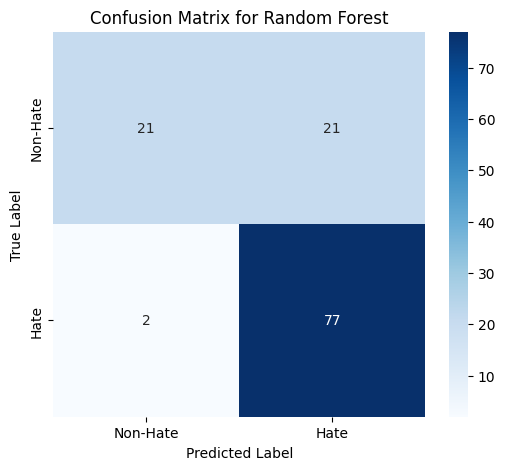


📌 Results for Support Vector Machine (SVM)
Accuracy: 0.8429752066115702
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.55      0.71        42
           1       0.81      1.00      0.89        79

    accuracy                           0.84       121
   macro avg       0.90      0.77      0.80       121
weighted avg       0.87      0.84      0.83       121



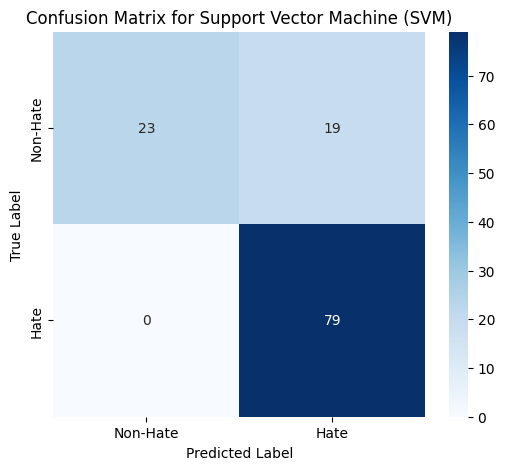


📌 Results for Multi-Layer Perceptron (MLP)
Accuracy: 0.8760330578512396
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.67      0.79        42
           1       0.85      0.99      0.91        79

    accuracy                           0.88       121
   macro avg       0.91      0.83      0.85       121
weighted avg       0.89      0.88      0.87       121



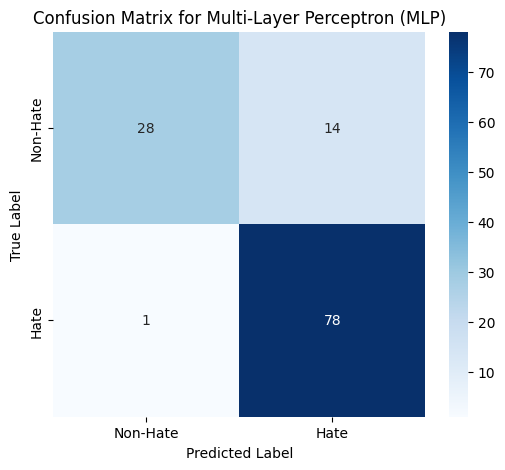


📌 Results for XGBoost
Accuracy: 0.8347107438016529
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.57      0.71        42
           1       0.81      0.97      0.89        79

    accuracy                           0.83       121
   macro avg       0.87      0.77      0.80       121
weighted avg       0.85      0.83      0.82       121



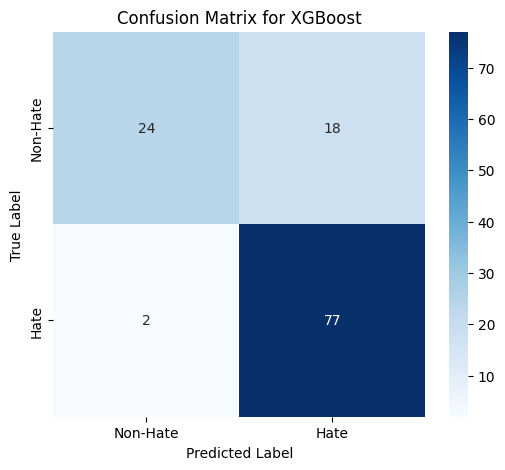

In [92]:
# List of classifiers to test
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Support Vector Machine (SVM)": SVC(kernel='rbf', probability=True, random_state=42),
    "Multi-Layer Perceptron (MLP)": MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=500, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    #"LightGBM": lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1),
    #"CatBoost": cb.CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6, verbose=0)
}

# Loop through classifiers and evaluate each
for name, model in classifiers.items():
    train_and_evaluate_model(model, X_train, y_train, X_test, y_test, name)


In [96]:
comb_df['Multi-class Label'] = audio_df['SHORT LABLE']

In [99]:
from sklearn.preprocessing import LabelEncoder

# Encode Multi-class Labels
label_encoder = LabelEncoder()
comb_df["Multi-class Label Encoded"] = label_encoder.fit_transform(comb_df["Multi-class Label"])

# Combine Audio and Text Features
X = np.hstack([np.stack(comb_df["Audio Features"].values), np.stack(comb_df["Text Features"].values)])
y = comb_df["Multi-class Label Encoded"]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

[0]	validation_0-mlogloss:1.43475
[1]	validation_0-mlogloss:1.34228
[2]	validation_0-mlogloss:1.28117
[3]	validation_0-mlogloss:1.24478
[4]	validation_0-mlogloss:1.19150
[5]	validation_0-mlogloss:1.16828
[6]	validation_0-mlogloss:1.13917
[7]	validation_0-mlogloss:1.11305
[8]	validation_0-mlogloss:1.10233
[9]	validation_0-mlogloss:1.08459
[10]	validation_0-mlogloss:1.08252
[11]	validation_0-mlogloss:1.07311
[12]	validation_0-mlogloss:1.07679
[13]	validation_0-mlogloss:1.07162
[14]	validation_0-mlogloss:1.06416
[15]	validation_0-mlogloss:1.05777
[16]	validation_0-mlogloss:1.05879
[17]	validation_0-mlogloss:1.05823
[18]	validation_0-mlogloss:1.07258
[19]	validation_0-mlogloss:1.07282
[20]	validation_0-mlogloss:1.07518
[21]	validation_0-mlogloss:1.07716
[22]	validation_0-mlogloss:1.08075
[23]	validation_0-mlogloss:1.07969
[24]	validation_0-mlogloss:1.08479
[25]	validation_0-mlogloss:1.08964
[26]	validation_0-mlogloss:1.08794
[27]	validation_0-mlogloss:1.09260
[28]	validation_0-mlogloss:1.0

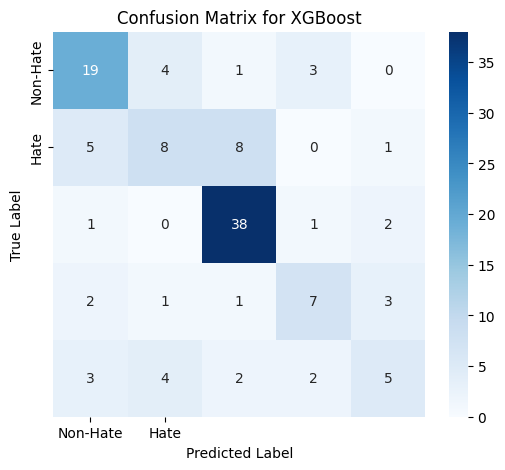

In [102]:
# Define XGBoost Classifier with verbose training output
xgb_clf = xgb.XGBClassifier(objective="multi:softmax", num_class=len(label_encoder.classes_), eval_metric="mlogloss", verbosity=2)

# Train Model (verbose training enabled)
xgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)

# Predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate Model
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Hate", "Hate"], yticklabels=["Non-Hate", "Hate"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for XGBoost")
plt.show()

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Random Forest Classification Report:
              precision    recall  f1-score   support

           C       0.53      0.74      0.62        27
           G       0.50      0.23      0.31        22
           N       0.68      0.93      0.79        42
           P       0.62      0.57      0.59        14
           R       0.00      0.00      0.00        16

    accuracy                           0.60       121
   macro avg       0.47      0.49      0.46       121
weighted avg       0.52      0.60      0.54       121



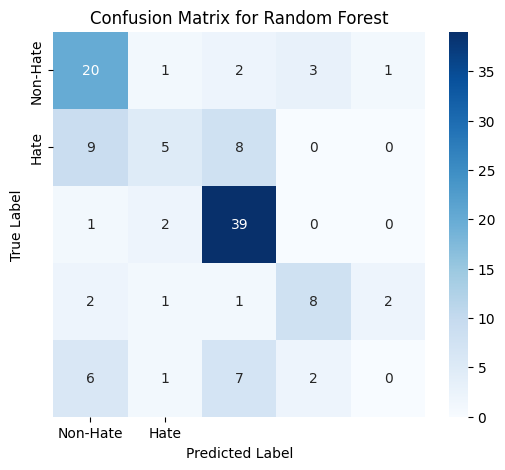

In [103]:
from tqdm import tqdm

# Define Classifier
rf_clf = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=-1)

# Train Model (training progress shown using tqdm)
print("Training Random Forest...")
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)

# Evaluate Model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Hate", "Hate"], yticklabels=["Non-Hate", "Hate"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for Random Forest")
plt.show() 

Training SVM...
[LibSVM]SVM Classification Report:
              precision    recall  f1-score   support

           C       0.55      0.78      0.65        27
           G       0.54      0.32      0.40        22
           N       0.69      0.83      0.75        42
           P       0.47      0.50      0.48        14
           R       0.25      0.06      0.10        16

    accuracy                           0.59       121
   macro avg       0.50      0.50      0.48       121
weighted avg       0.55      0.59      0.55       121



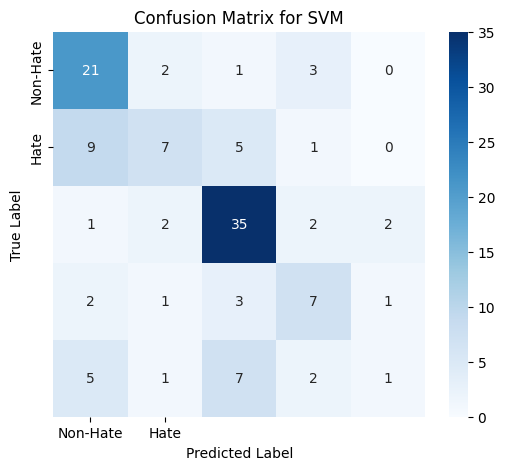

In [104]:
# Define Classifier
svm_clf = SVC(kernel="rbf", decision_function_shape="ovo", verbose=True)

# Train Model (verbose training output)
print("Training SVM...")
svm_clf.fit(X_train, y_train)

# Predictions
y_pred = svm_clf.predict(X_test)

# Evaluate Model
print("SVM Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Hate", "Hate"], yticklabels=["Non-Hate", "Hate"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for SVM")
plt.show()


Training MLP Classifier...
Iteration 1, loss = 1.56850376
Iteration 2, loss = 1.45652361
Iteration 3, loss = 1.34748438
Iteration 4, loss = 1.25636040
Iteration 5, loss = 1.18980939
Iteration 6, loss = 1.12734482
Iteration 7, loss = 1.06332394
Iteration 8, loss = 1.01491688
Iteration 9, loss = 0.95130306
Iteration 10, loss = 0.92437247
Iteration 11, loss = 0.87982300
Iteration 12, loss = 0.83152032
Iteration 13, loss = 0.81494502
Iteration 14, loss = 0.77904797
Iteration 15, loss = 0.76067725
Iteration 16, loss = 0.72775040
Iteration 17, loss = 0.72154204
Iteration 18, loss = 0.70107788
Iteration 19, loss = 0.65986156
Iteration 20, loss = 0.63749018
Iteration 21, loss = 0.60283046
Iteration 22, loss = 0.57747810
Iteration 23, loss = 0.56501209
Iteration 24, loss = 0.53256727
Iteration 25, loss = 0.51881013
Iteration 26, loss = 0.52244655
Iteration 27, loss = 0.52783872
Iteration 28, loss = 0.51111447
Iteration 29, loss = 0.47443704
Iteration 30, loss = 0.42518944
Iteration 31, loss = 0

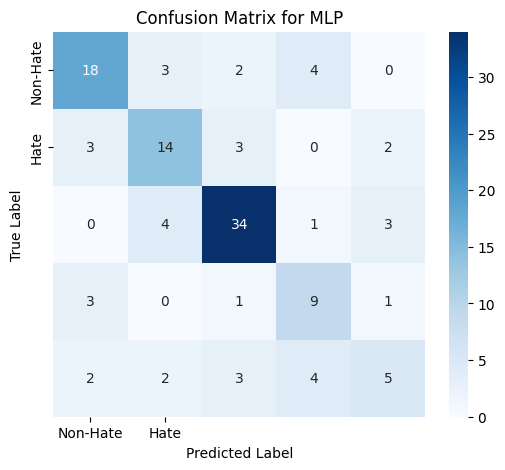

In [105]:
# Define Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(512, 256, 128), max_iter=500, verbose=True)

# Train Model (verbose training output)
print("Training MLP Classifier...")
mlp_clf.fit(X_train, y_train)

# Predictions
y_pred = mlp_clf.predict(X_test)

# Evaluate Model
print("MLP Classifier Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Hate", "Hate"], yticklabels=["Non-Hate", "Hate"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for MLP")
plt.show()